# Air Quality

Predicting air quality with Prophet
Feature description [here](https://www.kaggle.com/sayakchakraborty/air-quality-prediction-of-relative-humidity)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

## Import dataset

In [2]:
DATAPATH = 'data/AirQualityUCI.csv'

data = pd.read_csv(DATAPATH, sep=';')
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [3]:
data.shape

(9471, 17)

In [4]:
data.dropna(axis=1, how='all', inplace=True)
data.dropna(axis=0, how='all', inplace=True)

In [5]:
data.shape

(9357, 15)

In [6]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


## Data cleaning and feature engineering

In [7]:
data['Date'] = pd.to_datetime(data['Date'])

In [8]:
for col in data.iloc[:,2:].columns:
    if data[col].dtypes == object:
        data[col] = data[col].str.replace(',', '.').astype('float')

In [9]:
def positive_average(num):
    return num[num > -200].mean()
    
daily_data = data.drop('Time', axis=1).groupby('Date').apply(positive_average)

In [10]:
daily_data.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,,,,,
2004-01-04,2.550000,1244.380952,310.125,11.971429,1010.428571,161.304348,880.666667,96.739130,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-05,2.056522,1097.500000,275.000,8.662500,913.708333,104.739130,918.083333,84.956522,1640.416667,904.625000,20.150000,52.183333,1.167312
2004-01-06,2.100000,1135.583333,NaN,12.375000,1021.875000,152.043478,896.791667,75.869565,1881.500000,1066.958333,20.325000,66.154167,1.533350
2004-01-07,2.162500,1130.583333,NaN,12.225000,1038.541667,139.695652,740.916667,113.434783,1854.250000,1059.625000,30.450000,39.691667,1.624108
2004-01-08,0.983333,974.166667,NaN,5.808333,792.583333,51.739130,880.083333,58.521739,1559.000000,670.583333,30.654167,42.120833,1.673521


In [11]:
daily_data.isna().sum() > 8

CO(GT)            True
PT08.S1(CO)      False
NMHC(GT)          True
C6H6(GT)         False
PT08.S2(NMHC)    False
NOx(GT)           True
PT08.S3(NOx)     False
NO2(GT)           True
PT08.S4(NO2)     False
PT08.S5(O3)      False
T                False
RH               False
AH               False
dtype: bool

In [12]:
daily_data = daily_data.iloc[:,(daily_data.isna().sum() <= 8).values]

In [13]:
daily_data.head()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,
2004-01-04,1244.380952,11.971429,1010.428571,880.666667,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-05,1097.500000,8.662500,913.708333,918.083333,1640.416667,904.625000,20.150000,52.183333,1.167312
2004-01-06,1135.583333,12.375000,1021.875000,896.791667,1881.500000,1066.958333,20.325000,66.154167,1.533350
2004-01-07,1130.583333,12.225000,1038.541667,740.916667,1854.250000,1059.625000,30.450000,39.691667,1.624108
2004-01-08,974.166667,5.808333,792.583333,880.083333,1559.000000,670.583333,30.654167,42.120833,1.673521


In [14]:
daily_data.shape

(391, 9)

In [15]:
daily_data = daily_data.dropna()

In [16]:
daily_data.shape

(383, 9)

In [17]:
weekly_data = daily_data.resample('W').mean()

In [18]:
weekly_data.head()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,
2004-01-04,1244.380952,11.971429,1010.428571,880.666667,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-11,1136.801760,11.674457,1009.344462,760.484990,1727.833075,1083.683747,24.564726,53.224017,1.526858
2004-01-18,1173.375000,13.429167,1050.458333,1490.333333,1448.541667,1196.333333,10.891667,77.000000,1.002796
2004-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
weekly_data = weekly_data.dropna()

In [20]:
weekly_data.shape

(73, 9)

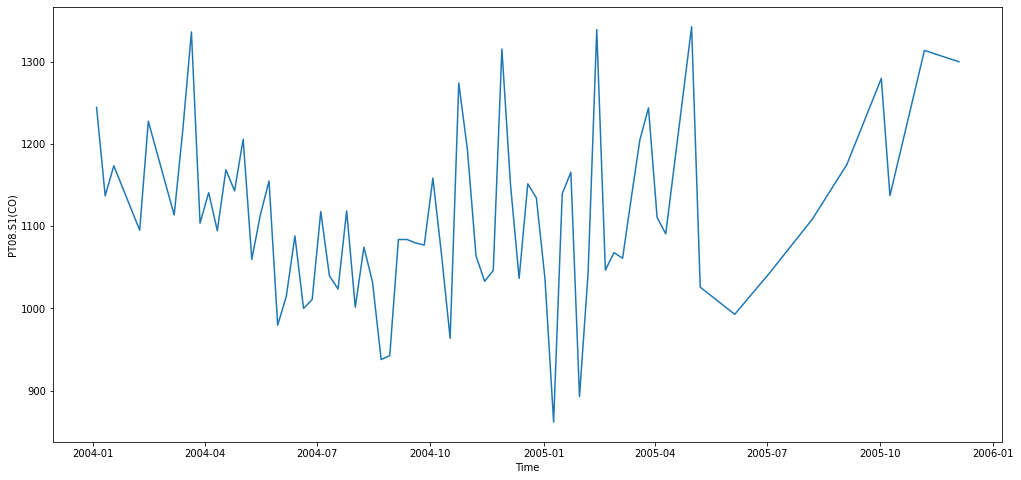

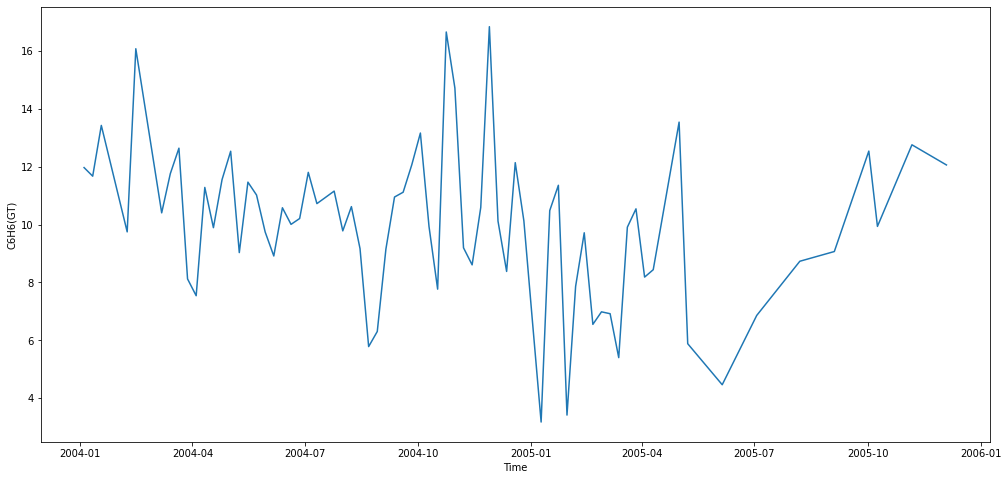

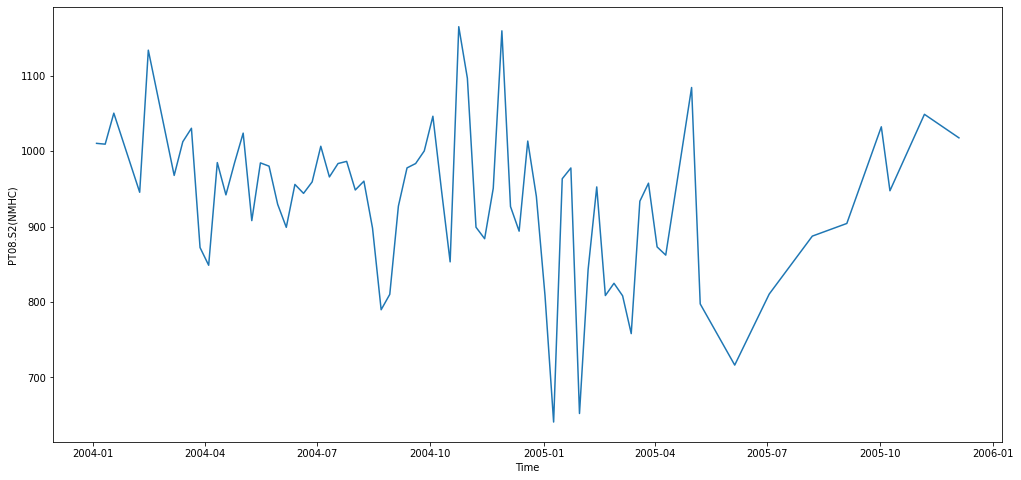

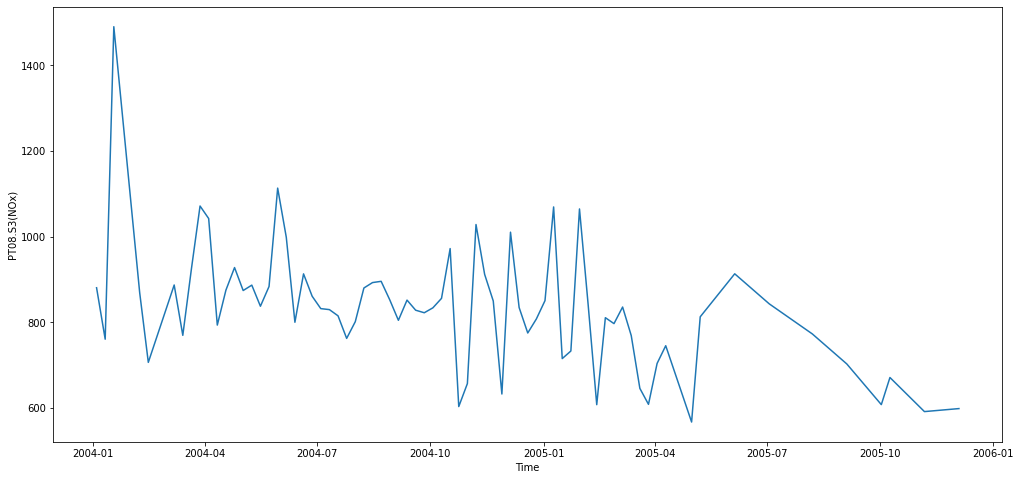

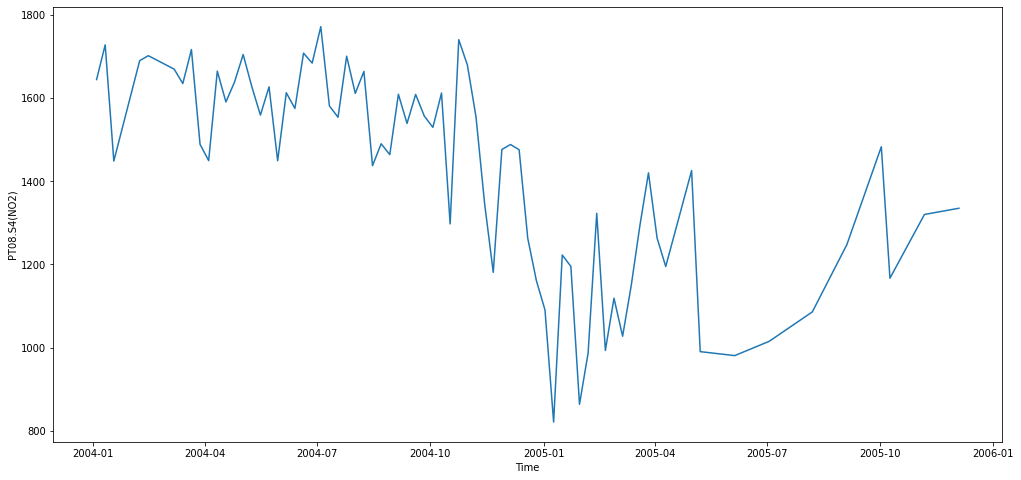

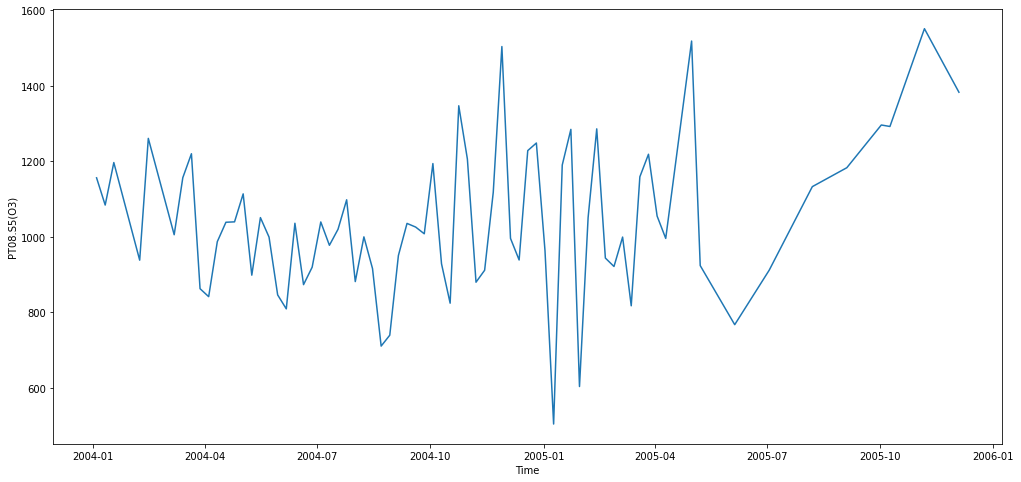

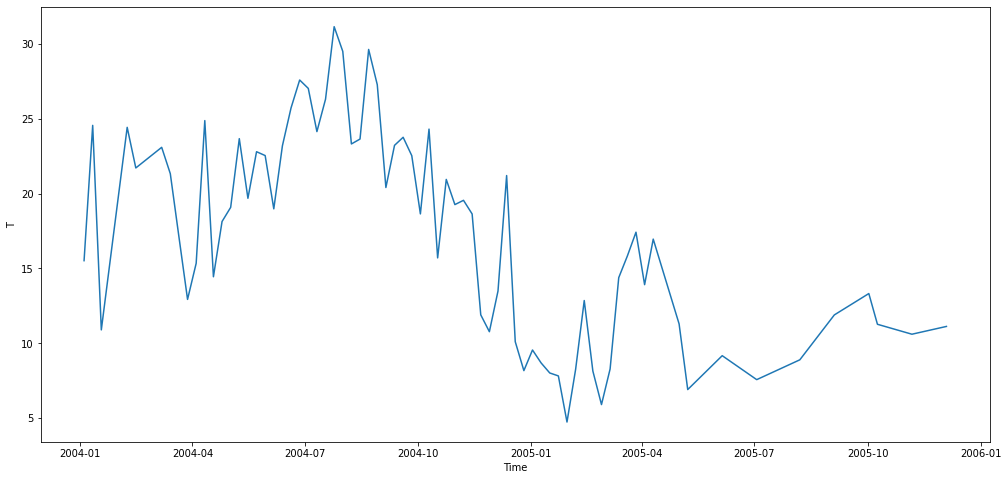

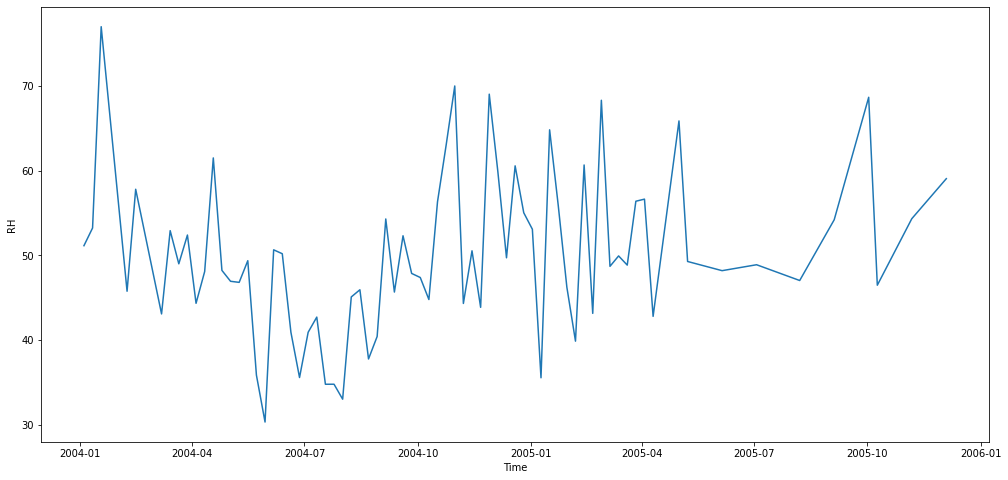

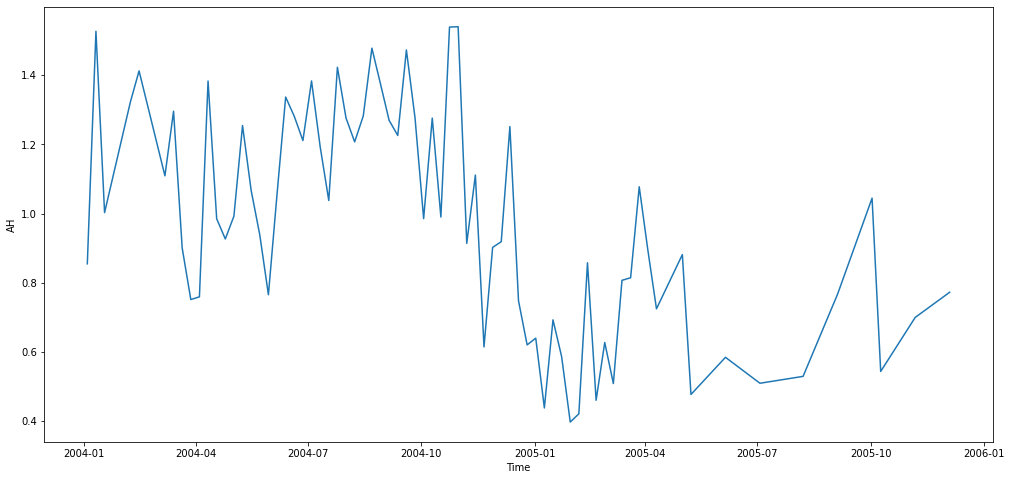

In [21]:
def plot_data(col):
    plt.figure(figsize=(17, 8))
    plt.plot(weekly_data[col])
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(False)
    plt.show()
    
for col in weekly_data.columns:
    plot_data(col)

## Modelling

Let's focus on predictig the concentration of NOx. Oxides of nitrogen react to form smog and acid rain, as well as being central to the formation of fine particles and ground level ozone, both of which are associated with adverse health effects.

In [22]:
cols_to_drop = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

weekly_data = weekly_data.drop(cols_to_drop, axis=1)

In [23]:
weekly_data.head()

,PT08.S3(NOx)
Date,
2004-01-04,880.666667
2004-01-11,760.484990
2004-01-18,1490.333333
2004-02-08,869.108333
2004-02-15,706.395833


In [24]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

In [25]:
df = weekly_data.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2004-01-04,880.666667
1,2004-01-11,760.484990
2,2004-01-18,1490.333333
3,2004-02-08,869.108333
4,2004-02-15,706.395833


In [26]:
prediction_size = 30
train_df = df[:-prediction_size]

In [27]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

In [29]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-01-04,947.675736,787.665784,1120.836478,947.675736,947.675736,0.0,0.0,0.0,0.0,0.0,0.0,947.675736
1,2004-01-11,944.838998,773.292308,1111.540860,944.838998,944.838998,0.0,0.0,0.0,0.0,0.0,0.0,944.838998
2,2004-01-18,942.002260,773.517276,1105.288044,942.002260,942.002260,0.0,0.0,0.0,0.0,0.0,0.0,942.002260
3,2004-02-08,933.492046,767.625448,1100.263268,933.492046,933.492046,0.0,0.0,0.0,0.0,0.0,0.0,933.492046
4,2004-02-15,930.655308,760.206606,1104.157770,930.655308,930.655308,0.0,0.0,0.0,0.0,0.0,0.0,930.655308


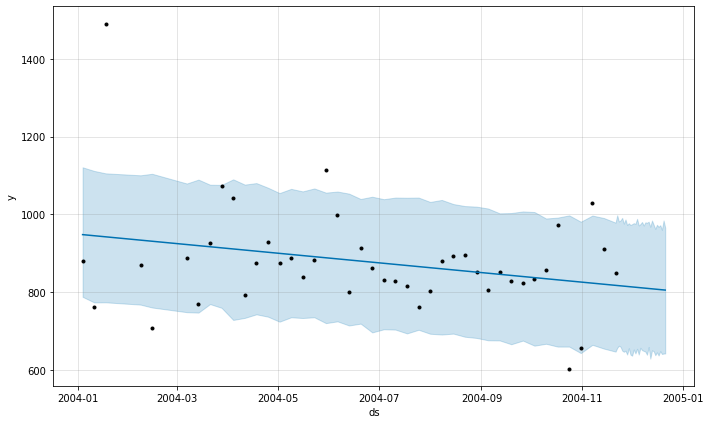

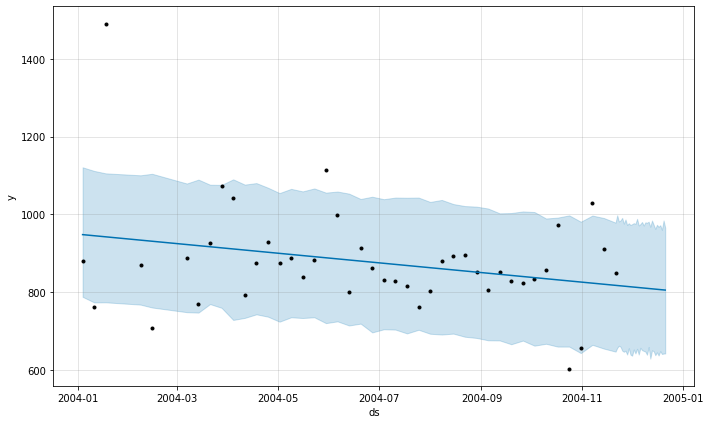

In [30]:
m.plot(forecast)

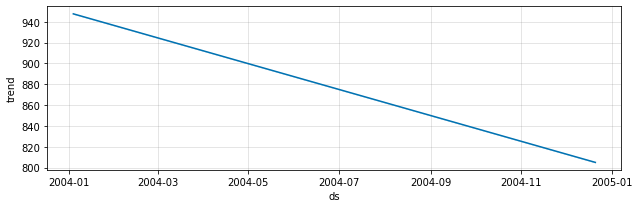

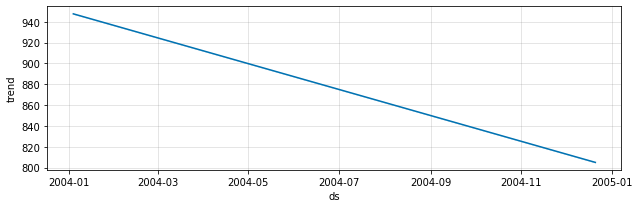

In [31]:
m.plot_components(forecast)

In [32]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [33]:
cmp_df = make_comparison_dataframe(df, forecast)

cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2004-01-04,947.675736,787.665784,1120.836478,880.666667
2004-01-11,944.838998,773.292308,1111.540860,760.484990
2004-01-18,942.002260,773.517276,1105.288044,1490.333333
2004-02-08,933.492046,767.625448,1100.263268,869.108333
2004-02-15,930.655308,760.206606,1104.157770,706.395833


In [34]:
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [35]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 13.874072034801495
MAE 109.32387955182077


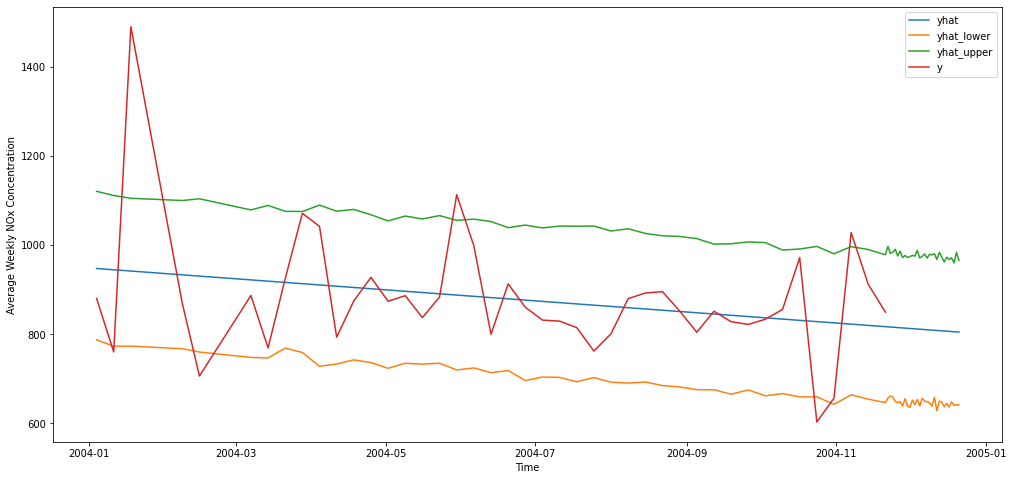

In [40]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'],label='yhat')
plt.plot(cmp_df['yhat_lower'],label='yhat_lower')
plt.plot(cmp_df['yhat_upper'],label='yhat_upper')
plt.plot(cmp_df['y'],label='y')
plt.xlabel('Time')
plt.ylabel('Average Weekly NOx Concentration')
plt.legend()
plt.grid(False)
plt.show()